In [1]:
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupKFold
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np
sys.path.append("../")
import preproc as preproc
import train as train
import tune as tune
import analysis as ana

Duplicate key in file '/Users/fu.j/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


In [2]:
# Same as Firnberg et al., 2014
AA_PROPERTY = {
    "W": "Aromatic",
    "F": "Aromatic",
    "Y": "Aromatic",
    "P": "Aliphatic",
    "M": "Aliphatic",
    "I": "Aliphatic",
    "L": "Aliphatic",
    "V": "Aliphatic",
    "A": "Aliphatic",
    "G": "Aliphatic",
    "C": "Polar uncharged",
    "S": "Polar uncharged",
    "T": "Polar uncharged",
    "Q": "Polar uncharged",
    "N": "Polar uncharged",
    "D": "Neg. charged",
    "E": "Neg. charged",
    "H": "Pos. charged",
    "R": "Pos. charged",
    "K": "Pos. charged",
}

# Protein property features (alanine scanning feature is not included).
DEMASK_FEATURES = ['entropy', 'log2f_var', 'matrix']

In [3]:
def preproc_demask_dmsas_data(input_data):
    """Impute, encode and weight DMS+AS data.
    """
    preproc_data = input_data.copy()
    preproc_data = preproc.impute_missing_value(preproc_data, None, ['AS_score'])
    # Encode wild-type & variant type amino acid with AS scores.
    preproc_data, encoded_col = preproc.encode_categorical_feature(preproc_data, ['aa1', 'aa2'], ['aa1', 'aa2'])
    preproc_data[encoded_col] = preproc_data[encoded_col].mul(preproc_data['AS_score'], axis='index')
    # Weight each variant.
    preproc_data = train.add_training_weight(preproc_data)
    return preproc_data, encoded_col

# Read data

In [4]:
# Normalized DMS data and DeMaSk features. Keep 'NA' in wt_mut.
norm_dms = pd.read_csv('../data/normalized/normalized_dms_DeMaSk_features.csv', 
                       index_col=0, na_values=[''], keep_default_na=False)
norm_as = pd.read_csv('../data/normalized/normalized_alanine_scanning.csv')

data_info = pd.read_csv('../data/data_info/dataset_info.csv', index_col=0)

# Compare with published (on going)

## Proposed

In [5]:
# LOPO CV on all DMS collected with no AS data (Our data & code).

# Weight each mutatnt.
work_data = train.add_training_weight(norm_dms)

# Leave-one-protein-out cross-validation
test_perf = dict()
for unip in work_data['uniprot_id'].unique():  
    # Train.
    train_data = work_data.query("uniprot_id != @unip")
    test_data = work_data.query("uniprot_id == @unip")
    train_data, test_data = train.refit_matrix_score(train_data, test_data)
    
    # Predict.
    model_features = ['entropy', 'log2f_var', 'matrix']
    estimator = LinearRegression(n_jobs=1)
    predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
    test_data['score_pred'] = predictor.predict(test_data[model_features])
    
    # Evaluate.
    for dms, df in test_data.groupby('dms_id'):
        test_perf[dms] = spearmanr(df['score'], df['score_pred'])[0]

In [7]:
# Collect results run by DeMaSk code. Results are not provided but available upon request.
#root = '/Users/fu.j/Documents/Codes_Data/demask/local_run'
comp_model = {'own_code': test_perf}
for exp_name in ['demask_web', 'dv12_all_rank']:
    files = os.listdir(f"{root}/result/{exp_name}")
    exp_result = dict()
    for file in files:
        if file == '.DS_Store':
            continue
        predicted = pd.read_csv(f"{root}/result/{exp_name}/{file}", sep='\t')
        experimental = pd.read_csv(f"{root}/data/dms_data/{exp_name}/{file}", sep='\t')
        merged = pd.merge(experimental, predicted, on=['pos', 'WT', 'var'], suffixes=['_exp', '_pred'], 
                          how='left', validate='1:1').dropna()  # Remove nonsense variants.
        exp_result[file[:-4]] = spearmanr(merged['score_exp'], merged['score_pred'])[0]
    comp_model[exp_name] = exp_result

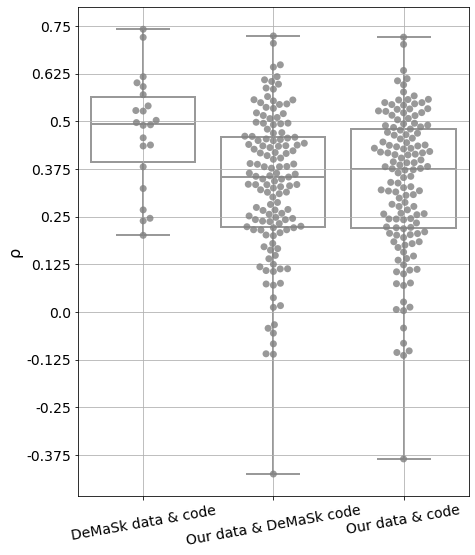

In [8]:
vis_data = pd.DataFrame(comp_model)
fig, ax = plt.subplots(1,1,figsize=(7,9), sharey=True)
fig.patch.set_facecolor('w')
order = ['demask_web', 'dv12_all_rank', 'own_code']
sns.swarmplot(data=vis_data, ax=ax, order=order, palette=['gray']*4, size=7, alpha=0.8, zorder=2)
sns.boxplot(data=vis_data, color='w', ax=ax, whis=np.inf, order=order, linewidth=2, zorder=1)
ax.set_yticks(np.arange(-0.375,0.875,0.125))
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_ylabel('ρ', fontsize=16)
ax.set_xticklabels(['DeMaSk data & code', 'Our data & DeMaSk code', 'Our data & code'], rotation=10, fontsize=14)
ax.grid()
plt.show()

## Main

In [5]:
# DMS data from the same target should be merged according to DeMaSk website.
merge_group_web = [['urn:mavedb:00000047-a-1', 'ccr5-2d7-bind', 'ccr5-gp120cd4-bind'],
                   ['urn:mavedb:00000048-a-1', 'cxcr4-12g5-bind', 'cxcr4-cxcl12-bind'],
                   ['tp53-null-etop', 'tp53-null-nultlin'],
                   ['urn:mavedb:00000037-a-1'], 
                   ['urn:mavedb:00000038-a-1', 'urn:mavedb:00000038-b-1', 'urn:mavedb:00000038-b-2', 
                    'E1_Ubiquitin'],
                   ['urn:mavedb:00000086-a-1', 'urn:mavedb:00000086-b-1', 'urn:mavedb:00000086-c-1',
                    'urn:mavedb:00000086-d-1', 'urn:mavedb:00000086-e-1', 'urn:mavedb:00000086-f-1'],
                   ['urn:mavedb:00000070-a-2'],
                   ['urn:mavedb:00000001-a-2','urn:mavedb:00000001-a-3'],
                   ['urn:mavedb:00000001-b-2'],
                   ['urn:mavedb:00000001-c-1'], 
                   ['urn:mavedb:00000001-d-1']]
merged_dms = []
for group in merge_group_web:
    df = norm_dms.query("dms_id in @group").copy()
    df = df.groupby(['u_pos', 'aa1', 'aa2', 'uniprot_id', 'sub_type'], as_index=False).mean()
    df['dms_id'] = group[0]
    merged_dms.append(df)
merged_dms = pd.concat(merged_dms)

In [11]:
# Weight each mutant.
weight = merged_dms.groupby(['uniprot_id', 'u_pos', 'aa2'])['score'].count()
weight = 1 / weight
weight.name = 'weight'
merged_dms = pd.merge(merged_dms, weight, left_on=['uniprot_id', 'u_pos', 'aa2'], right_index=True,
                      how='outer', validate='m:1').reset_index(drop=True)

In [7]:
test_perf = dict()
for unip in merged_dms['uniprot_id'].unique():  # Leave-one-protein-out cross-validation
    # Train.
    train_data = merged_dms.query("uniprot_id != @unip")
    test_data = merged_dms.query("uniprot_id == @unip")
    train_data, test_data = train.refit_matrix_score(train_data, test_data)
    
    # Predict.
    model_features = ['entropy', 'log2f_var', 'matrix']
    estimator = LinearRegression(n_jobs=1)
    predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
    test_data['score_pred'] = predictor.predict(test_data[model_features])
    
    # Evaluate.
    for dms, df in test_data.groupby('dms_id'):
        test_perf[dms] = spearmanr(df['score'], df['score_pred'])[0]

In [8]:
# Compare with result run by DeMaSk code.
root = '/Users/fu.j/Documents/Codes_Data/demask/local_run'
comp_model = {'own_code': test_perf}
for exp_name in ['demask_web_share', 'self_download_merge_web']:
    files = os.listdir(f"{root}/result/{exp_name}")
    exp_result = dict()
    for file in files:
        if file == '.DS_Store':
            continue
        predicted = pd.read_csv(f"{root}/result/{exp_name}/{file}", sep='\t')
        experimental = pd.read_csv(f"{root}/data/dms_data/{exp_name}/{file}", sep='\t')
        merged = pd.merge(experimental, predicted, on=['pos', 'WT', 'var'], suffixes=['_exp', '_pred'], 
                          how='left', validate='1:1').dropna()  # Nonsense variant exists.
        exp_result[file[:-4]] = spearmanr(merged['score_exp'], merged['score_pred'])[0]
    comp_model[exp_name] = exp_result

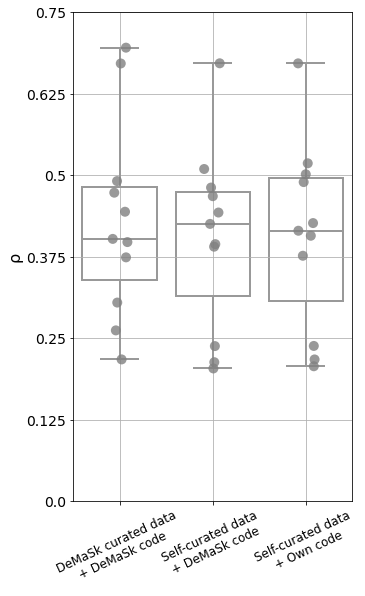

In [49]:
vis_data = pd.DataFrame(comp_model)
fig, ax = plt.subplots(1,1,figsize=(5,9), sharey=True)
order = ['demask_web_share', 'self_download_merge_web', 'own_code']
sns.stripplot(data=vis_data, ax=ax, order=order, palette=['gray']*4, size=10, alpha=0.8)
sns.boxplot(data=vis_data, color='w', ax=ax, whis=np.inf, order=order, linewidth=2)
ax.set_yticks(np.arange(0,0.875,0.125))
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_ylabel('ρ', fontsize=16)
ax.set_xticklabels(['DeMaSk curated data\n+ DeMaSk code', 'Self-curated data\n+ DeMaSk code', 
                    'Self-curated data\n+ Own code'], rotation=25, fontsize=12)
ax.grid()
plt.show()

## Extra

In [66]:
demask_curated = pd.read_csv('/Users/fu.j/AnacondaProjects/Project_3_extrapolation_model/data/dmsa_data/demask_train/demask_train_220311.csv',
                             index_col=0, na_values=[''], keep_default_na=False)
merge_group_demask= [['firnberg2014'],
                     ['giacomelli2018'],
                     ['heredia2018c'],
                     ['heredia2018x'],
                     ['roscoe2013'],
                     ['roscoe2014'],
                     ['stiffler2015'],
                     ['weile2017c'],
                     ['weile2017s'],
                     ['weile2017t'],
                     ['weile2017u']]
merged_dms = []
for group in merge_group_demask:
    df = demask_curated.query("dms_id in @group").copy()
    df = df.groupby(['dms_id', 'position', 'aa2', 'uniprot_id', 'aa1', 'sub_type'], as_index=False).first()[['uniprot_id', 'u_pos', 'aa2', 'entropy', 'log2f_var', 'matrix', 'score', 'dms_id', 'aa1', 'position', 'sub_type']]
    merged_dms.append(df)
merged_dms = pd.concat(merged_dms)

In [70]:
# Weight each mutatnt.
weight = merged_dms.groupby(['uniprot_id', 'u_pos', 'aa2'])['score'].count()
weight = 1 / weight
weight.name = 'weight'
merged_dms = pd.merge(merged_dms, weight, left_on=['uniprot_id', 'u_pos', 'aa2'], right_index=True,
                      how='outer', validate='m:1').reset_index(drop=True)

In [71]:
test_perf = dict()
for unip in merged_dms['uniprot_id'].unique():  # Leave-one-protein-out cross-validation
    # Train.
    train_data = merged_dms.query("uniprot_id != @unip")
    test_data = merged_dms.query("uniprot_id == @unip")
    train_data, test_data = train.refit_matrix_score(train_data, test_data)
    
    # Predict.
    model_features = ['entropy', 'log2f_var', 'matrix']
    estimator = LinearRegression(n_jobs=1)
    predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
    test_data['score_pred'] = predictor.predict(test_data[model_features])
    
    # Evaluate.
    for dms, df in test_data.groupby('dms_id'):
        test_perf[dms] = spearmanr(df['score'], df['score_pred'])[0]
comp_model['own_code_demask_curated'] = test_perf

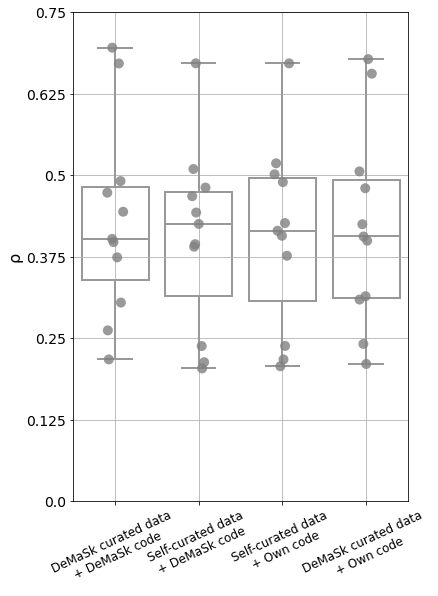

In [77]:
vis_data = pd.DataFrame(comp_model)
fig, ax = plt.subplots(1,1,figsize=(6,9), sharey=True)
order = ['demask_web_share', 'self_download_merge_web', 'own_code', 'own_code_demask_curated']
sns.stripplot(data=vis_data, ax=ax, order=order, palette=['gray']*4, size=10, alpha=0.8)
sns.boxplot(data=vis_data, color='w', ax=ax, whis=np.inf, order=order, linewidth=2)
ax.set_yticks(np.arange(0,0.875,0.125))
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_ylabel('ρ', fontsize=16)
ax.set_xticklabels(['DeMaSk curated data\n+ DeMaSk code', 'Self-curated data\n+ DeMaSk code', 
                    'Self-curated data\n+ Own code', 'DeMaSk curated data\n+ Own code'], rotation=25, fontsize=12)
ax.grid()
plt.show()

## DV12

In [17]:
# Weight each mutatnt.
weight = norm_dms.groupby(['uniprot_id', 'u_pos', 'aa2'])['score'].count()
weight = 1 / weight
weight.name = 'weight'
work_data = pd.merge(norm_dms, weight, left_on=['uniprot_id', 'u_pos', 'aa2'], right_index=True,
                      how='outer', validate='m:1').reset_index(drop=True)

test_perf = dict()
for unip in work_data['uniprot_id'].unique():  # Leave-one-protein-out cross-validation
    # Train.
    train_data = work_data.query("uniprot_id != @unip")
    test_data = work_data.query("uniprot_id == @unip")
    train_data, test_data = train.refit_matrix_score(train_data, test_data)
    
    # Predict.
    model_features = ['entropy', 'log2f_var', 'matrix']
    estimator = LinearRegression(n_jobs=1)
    predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
    test_data['score_pred'] = predictor.predict(test_data[model_features])
    
    # Evaluate.
    for dms, df in test_data.groupby('dms_id'):
        test_perf[dms] = spearmanr(df['score'], df['score_pred'])[0]

In [100]:
# Compare with result run by DeMaSk code.
root = '/Users/fu.j/Documents/Codes_Data/demask/local_run'
comp_model = {'own_code': test_perf}
for exp_name in ['demask_web', 'dv12_all_rank']:
    files = os.listdir(f"{root}/result/{exp_name}")
    exp_result = dict()
    for file in files:
        if file == '.DS_Store':
            continue
        predicted = pd.read_csv(f"{root}/result/{exp_name}/{file}", sep='\t')
        experimental = pd.read_csv(f"{root}/data/dms_data/{exp_name}/{file}", sep='\t')
        merged = pd.merge(experimental, predicted, on=['pos', 'WT', 'var'], suffixes=['_exp', '_pred'], 
                          how='left', validate='1:1').dropna()  # Nonsense variant exists.
        exp_result[file[:-4]] = spearmanr(merged['score_exp'], merged['score_pred'])[0]
    comp_model[exp_name] = exp_result

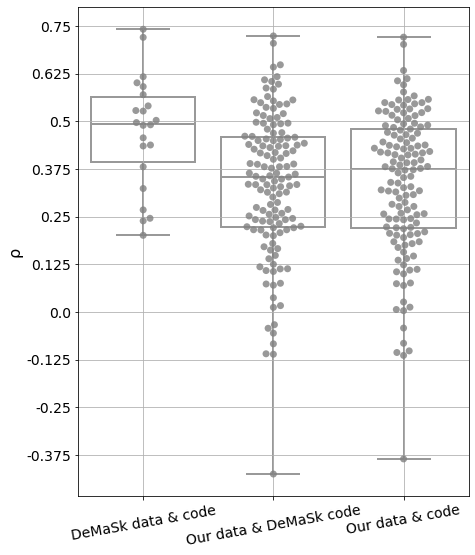

In [99]:
vis_data = pd.DataFrame(comp_model)
fig, ax = plt.subplots(1,1,figsize=(7,9), sharey=True)
order = ['demask_web', 'dv12_all_rank', 'own_code']
#sns.stripplot(data=vis_data, ax=ax, order=order, palette=['gray']*4, size=10, alpha=0.5, jitter=0.2)
sns.swarmplot(data=vis_data, ax=ax, order=order, palette=['gray']*4, size=7, alpha=0.8, zorder=2)
sns.boxplot(data=vis_data, color='w', ax=ax, whis=np.inf, order=order, linewidth=2, zorder=1)
ax.set_yticks(np.arange(-0.375,0.875,0.125))
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_ylabel('ρ', fontsize=16)
ax.set_xticklabels(['DeMaSk data & code', 'Our data & DeMaSk code', 
                    'Our data & code'], rotation=10, fontsize=14)
ax.grid()
plt.show()

In [103]:
work_data = norm_dms.copy()
work_data['weight'] = 1

test_nonweight = dict()
for unip in work_data['uniprot_id'].unique():  # Leave-one-protein-out cross-validation
    # Train.
    train_data = work_data.query("uniprot_id != @unip")
    test_data = work_data.query("uniprot_id == @unip")
    train_data, test_data = train.refit_matrix_score(train_data, test_data)
    
    # Predict.
    model_features = ['entropy', 'log2f_var', 'matrix']
    estimator = LinearRegression(n_jobs=1)
    predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
    test_data['score_pred'] = predictor.predict(test_data[model_features])
    
    # Evaluate.
    for dms, df in test_data.groupby('dms_id'):
        test_nonweight[dms] = spearmanr(df['score'], df['score_pred'])[0]

In [104]:
# Compare with result run by DeMaSk code.
root = '/Users/fu.j/Documents/Codes_Data/demask/local_run'
comp_model = {'own_code': test_perf, 'own_code_nonweight': test_nonweight}
for exp_name in ['demask_web', 'dv12_all_rank', 'dv12_all_nonrank']:
    files = os.listdir(f"{root}/result/{exp_name}")
    exp_result = dict()
    for file in files:
        if file == '.DS_Store':
            continue
        predicted = pd.read_csv(f"{root}/result/{exp_name}/{file}", sep='\t')
        experimental = pd.read_csv(f"{root}/data/dms_data/{exp_name}/{file}", sep='\t')
        merged = pd.merge(experimental, predicted, on=['pos', 'WT', 'var'], suffixes=['_exp', '_pred'], 
                          how='left', validate='1:1').dropna()  # Nonsense variant exists.
        exp_result[file[:-4]] = spearmanr(merged['score_exp'], merged['score_pred'])[0]
    comp_model[exp_name] = exp_result

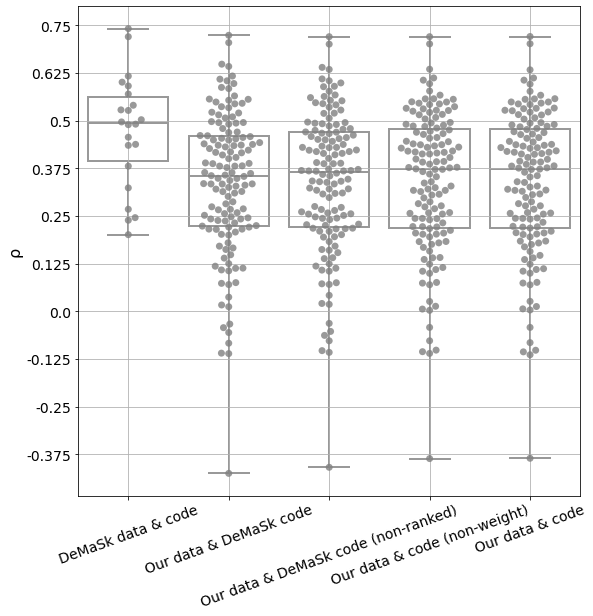

In [105]:
vis_data = pd.DataFrame(comp_model)
fig, ax = plt.subplots(1,1,figsize=(9,9), sharey=True)
order = ['demask_web', 'dv12_all_rank', 'dv12_all_nonrank', 'own_code_nonweight', 'own_code']
#sns.stripplot(data=vis_data, ax=ax, order=order, palette=['gray']*4, size=10, alpha=0.5, jitter=0.2)
sns.swarmplot(data=vis_data, ax=ax, order=order, palette=['gray']*4, size=7, alpha=0.8, zorder=2)
sns.boxplot(data=vis_data, color='w', ax=ax, whis=np.inf, order=order, linewidth=2, zorder=1)
ax.set_yticks(np.arange(-0.375,0.875,0.125))
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_ylabel('ρ', fontsize=16)
ax.set_xticklabels(['DeMaSk data & code', 'Our data & DeMaSk code', 'Our data & DeMaSk code (non-ranked)', 
                    'Our data & code (non-weight)', 'Our data & code'], rotation=20, fontsize=14)
ax.grid()
plt.show()

# Envision-based predictor

## Data preparation

In [5]:
# Pick AS subset that are highly compatibility with given DMS assay.
comp_as_id = data_info.query("assumed_compatibility == 'High'")[['dms_id', 'Ascan_id']]
comp_as = pd.merge(norm_as, comp_as_id, on='Ascan_id', how='outer')

In [6]:
# Merge AS data and DMS data with Envision feature.
norm_dms_env = pd.read_csv('../data/normalized/normalized_dms_Envision_features.csv', 
                           index_col=0, na_values=[''], keep_default_na=False)
dmsas_env = pd.merge(norm_dms_env, comp_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                     on=['dms_id', 'u_pos'], how='left')
dmsas_env['dmsa_id'] = dmsas_env['dms_id'] + '@' + dmsas_env['Ascan_id'].astype(str)
dmsas_env['Ascan_score_avail'] = ~dmsas_env['AS_score'].isna()
dmsas_env = train.add_training_weight(dmsas_env)

# Preprocess data: impute missing values and encode categorical features.
features = ['aa1', 'aa2', 'wt_mut', 'aa1_polarity', 'aa2_polarity', 'aa1_PI','aa2_PI', 'deltaPI', 
            'Grantham', 'aa1_weight', 'aa2_weight', 'deltaWeight', 'aa1vol', 'aa2vol', 'deltavolume',
            'aa1_psic', 'aa2_psic', 'delta_psic', 'accessibility', 'dssp_sec_str', 'phi_psi_reg',
            'delta_solvent_accessibility', 'b_factor', 'mut_msa_congruency', 'seq_ind_closest_mut', 
            'mut_mut_msa_congruency', 'evolutionary_coupling_avg']
categ_feat = ['aa1', 'aa2', 'wt_mut', 'aa1_polarity', 'aa2_polarity', 'dssp_sec_str', 'phi_psi_reg']
numer_feat = [x for x in features if x not in categ_feat]
dmsas_env = preproc.impute_missing_value(dmsas_env, categ_feat, numer_feat+['AS_score'])
dmsas_env, encoded_col = preproc.encode_categorical_feature(dmsas_env, categ_feat, ['aa1', 'aa2'])
envision_features = encoded_col + numer_feat

## Modelling

### Envision-based model

In [11]:
# Set parameters.

# These are trial parameters which are faster to run, but may still take hours (~2h on MacBook Pro 15-inch. 2018).
seed = 0
output_dir = '../result/prediction/alternative_models/envision/trial/'
# Hyper-parameter space to be optimized by tuning.
search_space = [{'name': 'n_estimators', 'type': 'discrete', 'domain': np.arange(1, 3), 'dtype': int},
                {'name': 'max_depth', 'type': 'discrete', 'domain': np.arange(1, 3), 'dtype': int}]
# Set arguments used by Bayesian Optimization model.
bo_kwargs = {'num_iterations': 1, 'num_cores': 1, 'if_maximize': True, 'random_seed': seed, 'max_time': 1000}
# Set cross-validation arguments.
cv_kwargs = {'scoring': 'neg_mean_squared_error', 'cv': GroupKFold(2), 'n_jobs': 4}

In [ ]:
"""
# These are the real parameters.
seed = 0
output_dir = '../result/prediction/alternative_models/envision/full_envision/'
search_space = [{'name':'n_estimators', 'type':'discrete', 'domain':np.arange(10, 51), 'dtype':int},
                {'name':'max_depth', 'type':'discrete', 'domain':np.arange(1, 81), 'dtype':int},
                {'name':'min_weight_fraction_leaf', 'type':'continuous', 'domain':(0.01,0.5), 'dtype':float}]
bo_kwargs = {'num_iterations': 500, 'num_cores': 1, 'if_maximize': True, 'random_seed': seed, 'max_time': 72000}
cv_kwargs = {'scoring': 'neg_mean_squared_error', 'cv': GroupKFold(30), 'n_jobs': 6}
"""

In [ ]:
# Leave-one-protein-out cross-validation
for unip in dmsas_env['uniprot_id'].unique():
    train_data = dmsas_env.query("uniprot_id != @unip")
    test_data_ori = dmsas_env.query("uniprot_id == @unip")
    cv_kwargs['fit_params'] = {'sample_weight': train_data['weight']}
    cv_kwargs['groups'] = train_data['uniprot_id']
    
    for model in ['with_as', 'no_as']:
        if model == 'with_as':
            model_features = envision_features + ['AS_score'] ########## Ascan_score_avail
        else:
            model_features = envision_features.copy()
        output_header = f"{output_dir}{unip}_{model}_"
        bo_kwargs['output_header'] = output_header

        # Training & testing.
        estimator = GradientBoostingRegressor(random_state=seed)
        predictor = tune.fit_best_estimator(search_space, estimator, train_data[model_features], 
                                              train_data['score'], cv_kwargs, bo_kwargs)
        test_data = test_data_ori.copy()
        test_data['pred_score'] = predictor.predict(test_data[model_features])
        
        # Saving results.
        test_data[["dmsa_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")
        tune.save_feature_importance(predictor, output_header)
        tune.save_tuned_hyperparameters(predictor, search_space, output_header)

### Comparison DeMaSk-based result

In [12]:
# Build DeMaSk-based predictor on the same subset of data (some proteins have no Envision features available).

comp_as_id = data_info.query("assumed_compatibility == 'High'")[['dms_id', 'Ascan_id']]
comp_as = pd.merge(norm_as, comp_as_id, on='Ascan_id', how='outer')

prot_with_envf = norm_dms_env.uniprot_id.unique()  # Proteins with Envision feature.
overlap_data = norm_dms.query("uniprot_id in @prot_with_envf")
dmsas_dem = pd.merge(overlap_data, comp_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                     on=['dms_id', 'u_pos'], how='left')
dmsas_dem['dmsa_id'] = dmsas_dem['dms_id'] + '@' + dmsas_dem['Ascan_id'].astype(str)
dmsas_dem['Ascan_score_avail'] = ~dmsas_dem['AS_score'].isna()
dmsas_dem, encoded_col = preproc_demask_dmsas_data(dmsas_dem)

In [13]:
output_dir = '../result/prediction/alternative_models/envision/demask_comparison/'
# Leave-one-protein-out cross-validation
for unip in dmsas_dem['uniprot_id'].unique():
    train_data = dmsas_dem.query("uniprot_id != @unip")
    test_data_ori = dmsas_dem.query("uniprot_id == @unip")
    train_data, test_data_ori = train.refit_matrix_score(train_data, test_data_ori)

    for model in ['with_as', 'no_as']:
        output_header = f"{output_dir}{unip}_{model}_"
        if model == 'with_as':
            model_features = DEMASK_FEATURES + encoded_col + ['AS_score']
        else:
            model_features = DEMASK_FEATURES.copy()

        estimator = LinearRegression(n_jobs=1)
        predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
        test_data = test_data_ori.copy()
        test_data['pred_score'] = predictor.predict(test_data[model_features])
        test_data[["dmsa_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")

## Evaluation

In [32]:
def read_lopo_prediction_result(result_dir, target_proteins):
    """Read leave-one-protein-out cross-validation results for using AS data or not.
    """
    results = dict()
    for model in ['with_as', 'no_as']:
        results[model] = pd.concat([pd.read_csv(f"{result_dir}{unip}_{model}_prediction.csv", index_col=0) 
                                    for unip in target_proteins])
    pred_merge = pd.merge(results['with_as'], results['no_as'], on=["dmsa_id", "position", "aa2", "score"],
                          validate="1:1", suffixes=["_ala", "_noala"], how='outer')
    return pred_merge

In [33]:
#env_based_pred = read_lopo_prediction_result('../result/prediction/alternative_models/envision/full_envision/', 
#                                             dmsas_env.uniprot_id.unique())
env_based_pred = read_lopo_prediction_result('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/08_220916_update/log/',
                                             dmsas_env[dmsas_env['Ascan_score_avail']].uniprot_id.unique())
dem_based_pred = read_lopo_prediction_result('../result/prediction/alternative_models/envision/demask_comparison/',
                                             dmsas_env.uniprot_id.unique())

In [34]:
# Evaluate performance with Spearman's ρ on each DMS-AS pair.
model_perform = []
for model, pred_result in {'Envision-based ± AS': env_based_pred, 'DeMaSk-based ± AS': dem_based_pred}.items():
    perf_with_as = ana.subgroup_spearmanr(pred_result, 'dmsa_id', 'score', 'pred_score_ala')
    perf_no_as = ana.subgroup_spearmanr(pred_result, 'dmsa_id', 'score', 'pred_score_noala')
    perf_merge = pd.merge(perf_with_as, perf_no_as[['rho']], left_index=True, right_index=True, validate="1:1", 
                          suffixes=["_ala", "_noala"], how='outer')
    perf_merge['model'] = model
    model_perform.append(perf_merge)
model_perform = pd.concat(model_perform)

# Post process.
model_perform.rename(columns={'rho_ala': 'With AS', 'rho_noala': 'No AS'}, inplace=True)
model_perform['diff_spear'] = model_perform['With AS'] - model_perform['No AS']
model_perform = pd.merge(model_perform, data_info, left_index=True, right_on='dmsa_id', how='left', validate='m:1')

In [35]:
if_one_residue = dmsas_env.groupby('dmsa_id')['u_pos'].nunique()
one_residue_filter = if_one_residue[if_one_residue == 1].index

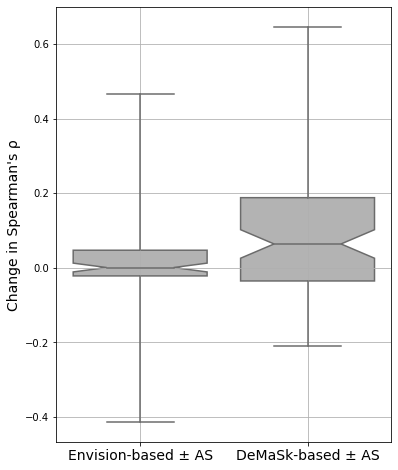

In [36]:
# Remove data that no or only one one residue has (filtered) AS score.
vis_data = model_perform[~model_perform['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")

fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

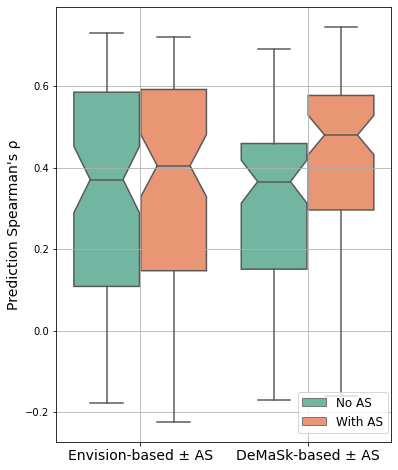

In [37]:
# Remove data that no or only one one residue has (filtered) AS score.
vis_data = model_perform[~model_perform['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")
vis_data = vis_data.melt(id_vars=['dmsa_id', 'model', 'size'], value_vars=['No AS', 'With AS'], value_name='spear', 
                         var_name='Feature')

fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='spear', hue='Feature', palette='Set2', notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_ylabel('Prediction Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.legend(loc=[0.72,0.02], fontsize=12)
ax.grid()
plt.show()

In [408]:
"""def read_foo(result_dir, target_proteins):
    """Read leave-one-protein-out cross-validation results for using AS data or not.
    """
    results = dict()
    for model in ['with_ala', 'nothing']:
        results[model] = pd.concat([pd.read_csv(f"{result_dir}{unip}_{model}_0_test_prediction.csv", index_col=0) 
                                    for unip in target_proteins]).rename(columns={'ob_score': 'score'})
    pred_merge = pd.merge(results['with_ala'], results['nothing'], on=["dmsa_id", "position", "aa2", "score"],
                          validate="1:1", suffixes=["_ala", "_noala"], how='outer')
    return pred_merge



env_based_pred = read_foo('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/08_v12_env/log/',
                                             dmsas_env[dmsas_env['Ascan_score_avail']].uniprot_id.unique())"""

## Tune optimization

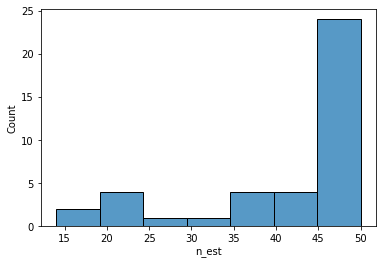

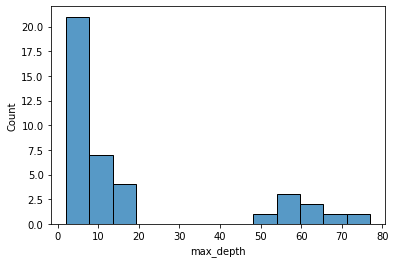

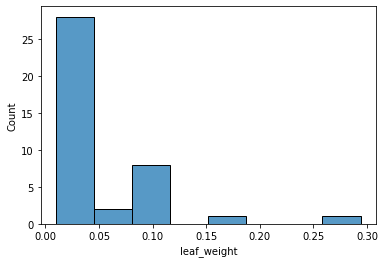

In [423]:
root = '/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/08_220916_update/log/'
tune_report = dict()
for file_name in os.listdir(root):
    if file_name[-10:] == 'report.txt':
        row = dict()
        with open(f"{root}{file_name}", 'r') as file:
            report = file.read()
        row['time'] = float(report.split('\n')[6].split(':')[1].strip().split(' ')[0])
        row['sample'] = int(report.split('\n')[3].split(':')[1].strip().split(',')[1].strip().split(' ')[0])
        opt_values = list(filter(None, report.split('\n')[-3].split(':')[1].strip().split(' ')))
        row['n_est'] = float(opt_values[0])
        row['max_depth'] = float(opt_values[1])
        row['leaf_weight'] = float(opt_values[2])
        tune_report[file_name[:-11]] = row
pd.DataFrame(tune_report).T.sort_values('sample')
for col in ['n_est', 'max_depth', 'leaf_weight']:
    sns.histplot(pd.DataFrame(tune_report).T[col])
    plt.show()

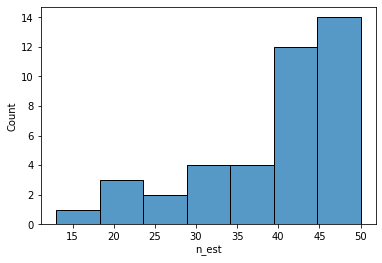

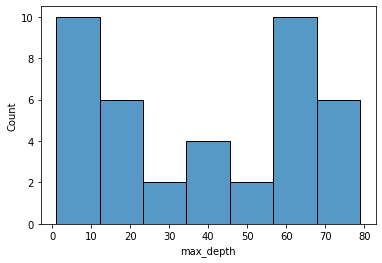

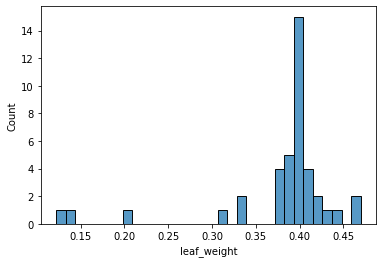

In [422]:
root = '/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/08_v12_env/log/'
tune_report = dict()
for file_name in os.listdir(root):
    if file_name[-10:] == 'report.txt':
        row = dict()
        with open(f"{root}{file_name}", 'r') as file:
            report = file.read()
        row['time'] = float(report.split('\n')[6].split(':')[1].strip().split(' ')[0])
        row['sample'] = int(report.split('\n')[3].split(':')[1].strip().split(',')[1].strip().split(' ')[0])
        opt_values = list(filter(None, report.split('\n')[-3].split(':')[1].strip().split(' ')))
        row['n_est'] = float(opt_values[0])
        row['max_depth'] = float(opt_values[1])
        row['leaf_weight'] = float(opt_values[2])
        tune_report[file_name[:-11]] = row
pd.DataFrame(tune_report).T.sort_values('sample')
for col in ['n_est', 'max_depth', 'leaf_weight']:
    sns.histplot(pd.DataFrame(tune_report).T[col])
    plt.show()

In [ ]:
# tune
models.fit_best_estimator
models.save_feature_importance
models.save_tuned_hyperparameters
models.monitor_process

# Replace AS with simulated scanning

## Training & testing

In [14]:
def model_simulated_scanning(dms_simscan, encoded_col, scan_aa2):
    """ Run leave-one-protein-out cross-validation on predicting with simulated scanning data.
    """
    # LOPO CV
    for unip in dms_simscan['uniprot_id'].unique():
        train_data = dms_simscan.query("uniprot_id != @unip")
        test_data_ori = dms_simscan.query("uniprot_id == @unip")
        train_data, test_data_ori = train.refit_matrix_score(train_data, test_data_ori)
        
        for model in ['with_simscan', 'no_simscan']:
            # Result of no simulated scanning score have nothing to do with scan_aa2, so the rest will be skipped.
            if (model=='no_simscan') & (scan_aa2!='A'):
                continue
            
            if model == 'with_simscan':
                model_features = DEMASK_FEATURES + encoded_col + ['scan_score']
                model = scan_aa2
            else:
                model_features = DEMASK_FEATURES.copy()
            output_header = f"../result/prediction/alternative_models/simulated_scan/{unip}_{model}_"

            estimator = LinearRegression(n_jobs=4)
            predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
            test_data = test_data_ori.copy()
            test_data['pred_score'] = predictor.predict(test_data[model_features])
            test_data[["dms_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")
    return

In [15]:
# Modelling. This may take about 30min on MacBook Pro 15-inch 2018.
for scan_aa2 in 'ACDEFGHIKLMNPQRSTVWY':
    # Pick DMS score of given variant type as simulated low-throughput scanning scores.
    sim_scan = norm_dms.query("aa2 == @scan_aa2")[['dms_id', 'position', 'score']]
    sim_scan.rename(columns={'score': 'scan_score'}, inplace=True)
    dms_simscan = pd.merge(norm_dms, sim_scan, on=['dms_id', 'position'], how='left', validate='m:1')
    
    # Impute, encode & weight.
    dms_simscan = preproc.impute_missing_value(dms_simscan, None, ['scan_score'])
    dms_simscan, encoded_col = preproc.encode_categorical_feature(dms_simscan, ['aa1', 'aa2'], ['aa1', 'aa2'])
    dms_simscan[encoded_col] = dms_simscan[encoded_col].mul(dms_simscan['scan_score'], axis='index')
    dms_simscan = train.add_training_weight(dms_simscan)
    
    model_simulated_scanning(dms_simscan, encoded_col, scan_aa2)

## Evaluation

In [23]:
# Result reading and evaluation.
simscan_perf = []
root = '../result/prediction/alternative_models/simulated_scan/'
for scan_aa2 in 'ACDEFGHIKLMNPQRSTVWYZ':
    if scan_aa2 == 'Z':  # Place holder
        model = 'no_simscan'
    else:
        model = scan_aa2
        
    onesim_result = pd.concat([pd.read_csv(f"{root}{unip}_{model}_prediction.csv", index_col=0) 
                               for unip in norm_dms.uniprot_id.unique()])
    onesim_result = onesim_result.query("aa2 != @scan_aa2")  # Remove scores used as feature already.
    
    # Calculate prediction performance by Spearman's correlation on each DMS dataset.
    onesim_perf = ana.subgroup_spearmanr(onesim_result, 'dms_id', 'score', 'pred_score')
    onesim_perf = onesim_perf.reset_index().rename(columns={'index': 'dms_id'})
    onesim_perf['scan_aa2'] = scan_aa2
    simscan_perf.append(onesim_perf)
simscan_perf = pd.concat(simscan_perf)

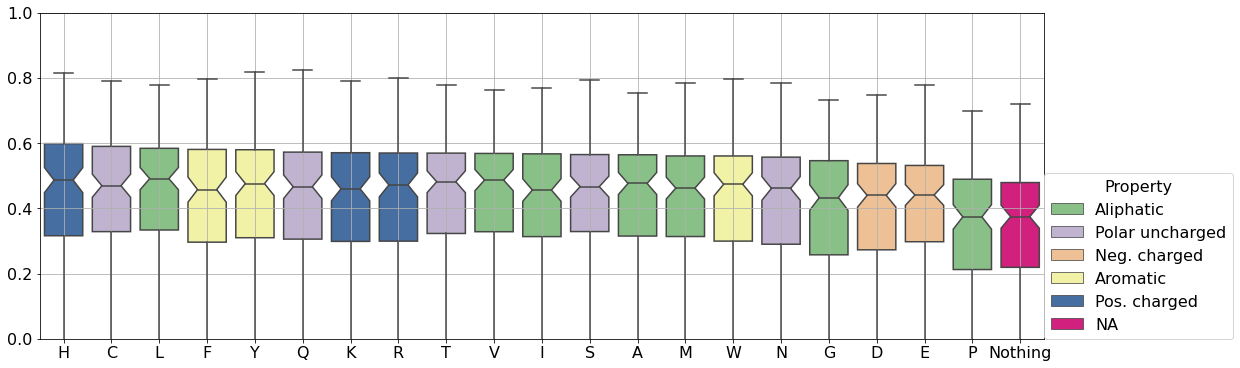

In [24]:
# Refine & add data info.
vis_data = simscan_perf.copy()
vis_data['scan_aa2'] = vis_data['scan_aa2'].replace({'Z': 'Nothing'})
vis_data['property'] = vis_data['scan_aa2'].map(AA_PROPERTY).fillna('NA')
    
fig, ax = plt.subplots(1,1,figsize=(18, 6))
fig.patch.set_facecolor('w')
order = list(vis_data.groupby('scan_aa2')[['rho']].quantile(0.75).sort_values('rho', ascending=False).index)
sns.boxplot(x='scan_aa2', y='rho', data=vis_data, hue='property', notch=True, dodge=False,
            whis=np.inf, ax=ax, order=order, palette='Accent')

# Aesthetics.
ax.legend(loc=[1,0], fontsize=16).set_title('Property',prop={'size':16})
ax.set_ylim([0,1])
ax.set_yticks([0.,0.2,0.4,0.6,0.8,1.])
ax.set_yticklabels([0.,0.2,0.4,0.6,0.8,1.], fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_ylabel('')
ax.set_xlabel('')
plt.grid()

plt.show()

# Boosting predictor

## Training & testing

In [16]:
# This part is the same as the data preparation for high compatibility filtering (P2-2.2.1)
# Pick AS subset that are highly compatibility with given DMS assay.
comp_as_id = data_info.query("assumed_compatibility == 'High'")[['dms_id', 'Ascan_id']]
comp_as = pd.merge(norm_as, comp_as_id, on='Ascan_id', how='outer')

dms_comp_as = pd.merge(norm_dms, comp_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                       on=['dms_id', 'u_pos'], how='left')
dms_comp_as['dmsa_id'] = dms_comp_as['dms_id'] + '@' + dms_comp_as['Ascan_id'].astype(str)
dms_comp_as['Ascan_score_avail'] = ~dms_comp_as['AS_score'].isna()
dms_comp_as, encoded_col = preproc_demask_dmsas_data(dms_comp_as)

In [17]:
def first_step_modelling(train_data_ori, test_data_ori, first_features):
    """First step of boosting prediction which uses no AS feature.
    """
    train_data = train_data_ori.copy()
    test_data = test_data_ori.copy()
    
    estimator = LinearRegression(n_jobs=1)
    predictor = estimator.fit(train_data[first_features], train_data['score'], train_data['weight'])
    
    train_data['first_pred'] = predictor.predict(train_data[first_features])
    train_data['diff_pred'] = train_data['score'] - train_data['first_pred']
    
    test_data['first_pred'] = predictor.predict(test_data[first_features])
    test_data['diff_pred'] = test_data['score'] - test_data['first_pred']
    return train_data, test_data


def second_step_modelling(train_data_ori, test_data_ori, second_features):
    """First step of boosting prediction which uses no AS feature.
    """
    train_data = train_data_ori.copy()
    test_data = test_data_ori.copy()
    
    train_data = train_data[train_data['Ascan_score_avail']].copy()  # Limit to data with AS scores.
    train_data = train.add_training_weight(train_data.drop(columns='weight'))  # Reset weight.
    
    estimator = LinearRegression(n_jobs=1)
    predictor = estimator.fit(train_data[second_features], train_data['diff_pred'], train_data['weight'])
    
    train_data['second_pred'] = predictor.predict(train_data[second_features])
    train_data['final_pred'] = train_data['first_pred'] + train_data['second_pred']
    
    test_data['second_pred'] = predictor.predict(test_data[second_features])
    test_data['final_pred'] = test_data['first_pred'] + test_data['second_pred']
    return train_data, test_data

In [18]:
# Modelling.
first_features = DEMASK_FEATURES.copy()
second_features = DEMASK_FEATURES + encoded_col + ['AS_score']

# Leave-one-protein-out cross-validation.
for unip in dms_comp_as['uniprot_id'].unique():  
    train_data = dms_comp_as.query("uniprot_id != @unip").copy()
    test_data = dms_comp_as.query("uniprot_id == @unip").copy()
    train_data, test_data = train.refit_matrix_score(train_data, test_data)
            
    # First step: no AS feature.
    train_data, test_data = first_step_modelling(train_data, test_data, first_features)
    # Second step: with AS feature.
    train_data, test_data = second_step_modelling(train_data, test_data, second_features)
    
    # Saving.
    output_header = f"../result/prediction/alternative_models/boosting/{unip}_"
    test_data[["dmsa_id", "position", "aa2", "score", "final_pred", "first_pred"]].to_csv(f"{output_header}prediction.csv")

## Evaluation

In [25]:
# Data reading and evaluation.
root = '../result/prediction/alternative_models/boosting/'
boosting_result = pd.concat([pd.read_csv(f"{root}{unip}_prediction.csv", index_col=0) 
                             for unip in norm_dms.uniprot_id.unique()])
boost_perf = ana.subgroup_spearmanr(boosting_result, 'dmsa_id', 'score', 'final_pred')

In [27]:
# Prepare data for visualisation.
# Get (one-step) compatibility filtering result for comparison.
root = '../result/prediction/linear_as/compatible_as/'
comp_filt_result = pd.concat([pd.read_csv(f"{root}{unip}_with_as_prediction.csv", index_col=0) 
                             for unip in norm_dms.uniprot_id.unique()])
comp_filt_perf = ana.subgroup_spearmanr(comp_filt_result, 'dmsa_id', 'score', 'pred_score')

# Merge performance results.
bench_data = pd.merge(boost_perf, comp_filt_perf, left_index=True, right_index=True, validate='1:1', 
                      how='outer', suffixes=['_boost', '_onestep'])
bench_data = bench_data[bench_data.index.str[-4:] != '@nan']  # Remove data without available (filtered) AS score.
bench_data['Protein name'] = bench_data.index.map(data_info.groupby('dmsa_id').protein_name.first())
bench_data = bench_data.rename(columns={'size_boost': 'Size'})  # size_boost and size_onestep are the same.

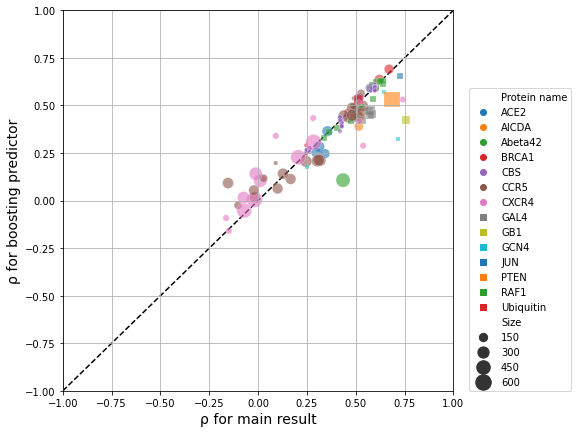

In [28]:
# Set makers.
order = np.sort(bench_data['Protein name'].unique())
half = int(len(order)/2)
markers = dict(zip(order, ['o']*half + ['s']*(len(order) - half)))

fig, ax = plt.subplots(1, 1, figsize=(7,7))
fig.patch.set_facecolor('w')
g = sns.scatterplot(data=bench_data, x='rho_onestep', y='rho_boost', size='Size', hue='Protein name', 
                    hue_order=order, style='Protein name', alpha=0.6, ax=ax, sizes=(15,250), 
                    palette="tab10", markers=markers)
ax.plot([-1,1],[-1,1], '--', c='k', zorder=0)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('ρ for main result', fontsize=14)
ax.set_ylabel('ρ for boosting predictor', fontsize=14)
ax.legend(loc=(1.04, 0))
ax.grid(zorder=0)
plt.show()

# Replace AS with DMS-Ala for training

## Training & testing

In [19]:
# Data preparation
# Data for training. With DMS score of alanine substitution (DMS-Ala) score replacing AS score.
sim_scan = norm_dms.query("aa2 == 'A'")[['dms_id', 'position', 'score']]
sim_scan.rename(columns={'score': 'AS_score'}, inplace=True)  # Easier to interpret, should actually be DMS-Ala.
dms_simscan = pd.merge(norm_dms, sim_scan, on=['dms_id', 'position'], how='left', validate='m:1')
dms_simscan, encoded_col = preproc_demask_dmsas_data(dms_simscan)

# Data for testing. With AS scores kept.
# This part is the same as the data preparation for training with all AS data (P2-2.1).
all_as = norm_as.copy()
dms_all_as = pd.merge(norm_dms, all_as[['uniprot_id', 'u_pos', 'Ascan_id', 'AS_score']], 
                      on=['uniprot_id', 'u_pos'], how='left')
dms_all_as['dmsa_id'] = dms_all_as['dms_id'] + '@' + dms_all_as['Ascan_id'].astype(str)
dms_all_as['Ascan_score_avail'] = ~dms_all_as['AS_score'].isna()
dms_all_as = preproc.impute_missing_value(dms_all_as, None, ['AS_score'])
dms_all_as, encoded_col = preproc.encode_categorical_feature(dms_all_as, ['aa1', 'aa2'], ['aa1', 'aa2'])
dms_all_as[encoded_col] = dms_all_as[encoded_col].mul(dms_all_as['AS_score'], axis='index')

In [20]:
# Modelling
for unip in dms_simscan['uniprot_id'].unique():
    train_data = dms_simscan.query("uniprot_id != @unip")  # Train data use DMS-Ala score.
    test_data = dms_all_as.query("uniprot_id == @unip").copy()  # Test data use AS score.
    train_data, test_data = train.refit_matrix_score(train_data, test_data)

    model_features = DEMASK_FEATURES + encoded_col + ['AS_score']
    output_header = f"../result/prediction/alternative_models/dms-ala_train/{unip}_"
    estimator = LinearRegression(n_jobs=4)
    predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
    test_data['pred_score'] = predictor.predict(test_data[model_features])
    test_data[["dmsa_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")

## Evaluation

In [29]:
# Data reading and evaluation.
root = '../result/prediction/alternative_models/dms-ala_train/'
dmsala_result = pd.concat([pd.read_csv(f"{root}{unip}_prediction.csv", index_col=0) 
                             for unip in norm_dms.uniprot_id.unique()])
dmsala_perf = ana.subgroup_spearmanr(dmsala_result, 'dmsa_id', 'score', 'pred_score')

In [30]:
# Prepare data for visualisation.
# Get compatibility filtering (AS trained) result for comparison.
root = '../result/prediction/linear_as/compatible_as/'
comp_filt_result = pd.concat([pd.read_csv(f"{root}{unip}_with_as_prediction.csv", index_col=0) 
                             for unip in norm_dms.uniprot_id.unique()])
comp_filt_perf = ana.subgroup_spearmanr(comp_filt_result, 'dmsa_id', 'score', 'pred_score')

# Merge performance results.
# Merge on right, keeping highly comparable data only, for comparison.
bench_data = pd.merge(dmsala_perf, comp_filt_perf, left_index=True, right_index=True, validate='1:1', 
                      how='right', suffixes=['_DMS-Alatrain', '_AStrain'])  
bench_data = bench_data[bench_data.index.str[-4:] != '@nan']  # Remove data without available (filtered) AS score.
bench_data['Protein name'] = bench_data.index.map(data_info.groupby('dmsa_id').protein_name.first())
bench_data = bench_data.rename(columns={'size_DMS-Alatrain': 'Size'})

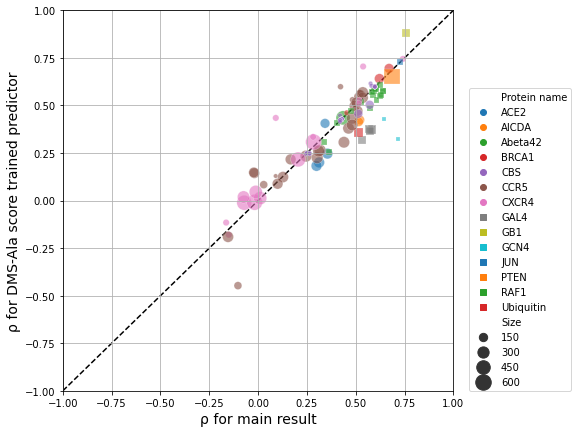

In [31]:
# Set makers.
order = np.sort(bench_data['Protein name'].unique())
half = int(len(order)/2)
markers = dict(zip(order, ['o']*half + ['s']*(len(order) - half)))

fig, ax = plt.subplots(1, 1, figsize=(7,7))
fig.patch.set_facecolor('w')
g = sns.scatterplot(data=bench_data, x='rho_AStrain', y='rho_DMS-Alatrain', size='Size', hue='Protein name', 
                    hue_order=order, style='Protein name', alpha=0.6, ax=ax, sizes=(15,250), 
                    palette="tab10", markers=markers)
ax.plot([-1,1],[-1,1], '--', c='k', zorder=0)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('ρ for main result', fontsize=14)
ax.set_ylabel('ρ for DMS-Ala score trained predictor', fontsize=14)
ax.legend(loc=(1.04, 0))
ax.grid(zorder=0)
plt.show()